# Dikemodel continued - subspace partitioning

Scenario discovery.... (nog uitleg toevoegen)

## 1. Apply scenario discovery

**1.** Import model from Open Exploration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
)
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation2 import get_model_for_problem_formulation, sum_over, sum_over_time

**2.** Import results from Open Exploration

bla bla importeren en levers weghalen



In [3]:
from ema_workbench import load_results

# Laad de resultaten
results = load_results('dike_open_exploration_results.tar.gz')
#results = load_results("dike_open_exploration_with_allcosts.tar.gz")
experiments, outcomes = results


lever_columns = [
    '0_RfR 0', '0_RfR 1', '0_RfR 2',
    '1_RfR 0', '1_RfR 1', '1_RfR 2',
    '2_RfR 0', '2_RfR 1', '2_RfR 2',
    '3_RfR 0', '3_RfR 1', '3_RfR 2',
    '4_RfR 0', '4_RfR 1', '4_RfR 2',
    'EWS_DaysToThreat',
    'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2',
    'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2',
    'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2',
    'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2',
    'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2'
]

cleaned_experiments = experiments.drop(columns=lever_columns)

In [4]:
cleaned_experiments

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail,discount rate 0,discount rate 1,discount rate 2,scenario,policy,model
0,103,217.683174,10.0,0.841797,270.954436,1.0,0.174278,337.892242,1.5,0.435198,...,0.805289,172.146890,1.5,0.750387,4.5,3.5,1.5,275,0,dikesnet
1,131,192.830558,10.0,0.380209,194.257699,1.0,0.834496,302.265017,1.0,0.835073,...,0.607969,272.172248,1.0,0.202772,4.5,3.5,2.5,276,0,dikesnet
2,24,119.543819,1.0,0.863675,249.308526,10.0,0.912437,253.897228,1.5,0.850463,...,0.918459,120.649992,1.0,0.244287,1.5,4.5,2.5,277,0,dikesnet
3,45,200.979780,1.0,0.834957,341.558981,1.0,0.183517,163.527760,1.0,0.956269,...,0.027734,308.861620,1.0,0.740133,1.5,2.5,3.5,278,0,dikesnet
4,58,164.877971,1.5,0.412863,258.608157,1.5,0.529751,153.842555,1.0,0.640369,...,0.360311,324.515517,10.0,0.031893,3.5,4.5,2.5,279,0,dikesnet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27495,109,171.222359,1.5,0.102939,58.239493,1.5,0.996751,236.126664,10.0,0.085617,...,0.467277,111.706043,10.0,0.662010,1.5,1.5,3.5,370,274,dikesnet
27496,3,43.605502,1.0,0.230537,150.495842,1.5,0.704171,93.156951,10.0,0.237641,...,0.490770,236.688722,10.0,0.991166,4.5,2.5,3.5,371,274,dikesnet
27497,78,72.980798,1.0,0.601053,61.602484,1.0,0.504269,318.892383,10.0,0.056292,...,0.272205,84.763100,10.0,0.845756,2.5,1.5,1.5,372,274,dikesnet
27498,56,62.319860,1.0,0.097715,71.585366,10.0,0.432779,349.205679,1.0,0.505066,...,0.632047,279.984917,10.0,0.103245,2.5,1.5,4.5,373,274,dikesnet


**3.** Apply scenario discovery

neem de data die onder de.... aan kosten is, doe daar een prim analyse op. je krijgt leuk plaatje

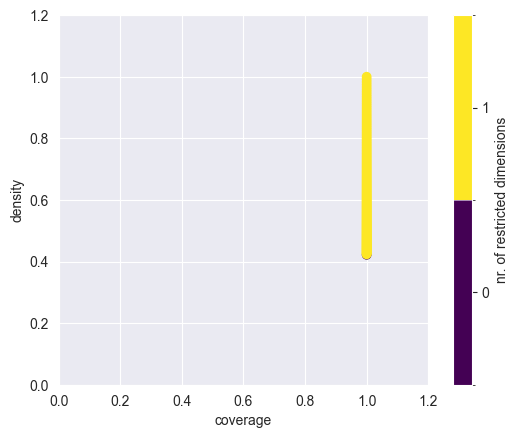

In [29]:
from ema_workbench.analysis import prim
import numpy as np

# See outcome
data_rfrtotalcost = outcomes['RfR Total Costs']

# Define wanted outcome
y_rfrtotalcost = ((data_rfrtotalcost >= 1000000000) & (data_rfrtotalcost <= 1400000000)).astype(bool)

# plt.hist(data_rfrtotalcost)

# PRIM-analyse
prim_alg_rfrtotalcost = prim.Prim(cleaned_experiments, y_rfrtotalcost, threshold=0.8)
box_rfrtotalcost = prim_alg_rfrtotalcost.find_box()
box_rfrtotalcost.show_tradeoff()
plt.show()


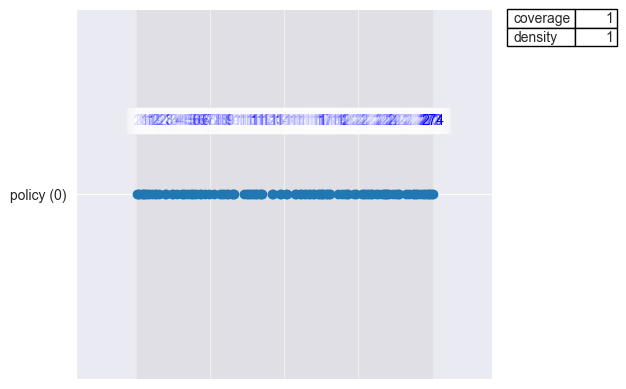

In [30]:
# box_rfrtotalcost.inspect()
box_rfrtotalcost.inspect(style='graph')
plt.show()

In [9]:
# x = cleaned_experiments.reset_index(drop=True)
# # Boolean array van experimenten in de box
# in_box_rfrtotalcost = box_rfrtotalcost.yi  # Deze is altijd even lang als x na reset_index
#
# # Selecteer de experimenten die in de box vallen
# experiments_in_box_rfrtotalcost = x.loc[in_box_rfrtotalcost]
#
# # Unieke policies selecteren
# robust_policies_rfrtotalcost = experiments_in_box_rfrtotalcost['policy'].unique()
#
# # Robuuste policies opzoeken in originele experimenten
# robust_policies_df_rfrtotalcost = experiments[experiments['policy'].isin(robust_policies_rfrtotalcost)].drop_duplicates(subset='policy')
#
# # Toon resultaat
# print("Robust Policies for RfR Total Costs:")
# display(robust_policies_df_rfrtotalcost)


Robust Policies for RfR Total Costs:


,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,EWS_DaysToThreat,scenario,policy,model
100,103,217.683174,10.0,0.841797,270.954436,1.0,0.174278,337.892242,1.5,0.435198,...,5,3,7,10,1,7,4,275,1,dikesnet
200,103,217.683174,10.0,0.841797,270.954436,1.0,0.174278,337.892242,1.5,0.435198,...,5,5,8,0,8,6,3,275,2,dikesnet
300,103,217.683174,10.0,0.841797,270.954436,1.0,0.174278,337.892242,1.5,0.435198,...,9,4,2,3,9,8,2,275,3,dikesnet
600,103,217.683174,10.0,0.841797,270.954436,1.0,0.174278,337.892242,1.5,0.435198,...,7,1,6,10,4,5,4,275,6,dikesnet
700,103,217.683174,10.0,0.841797,270.954436,1.0,0.174278,337.892242,1.5,0.435198,...,2,7,2,1,0,7,3,275,7,dikesnet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27000,103,217.683174,10.0,0.841797,270.954436,1.0,0.174278,337.892242,1.5,0.435198,...,10,4,6,10,10,10,0,275,270,dikesnet
27100,103,217.683174,10.0,0.841797,270.954436,1.0,0.174278,337.892242,1.5,0.435198,...,6,9,2,6,3,4,3,275,271,dikesnet
27200,103,217.683174,10.0,0.841797,270.954436,1.0,0.174278,337.892242,1.5,0.435198,...,7,10,10,2,8,9,1,275,272,dikesnet
27300,103,217.683174,10.0,0.841797,270.954436,1.0,0.174278,337.892242,1.5,0.435198,...,5,0,1,10,6,0,1,275,273,dikesnet


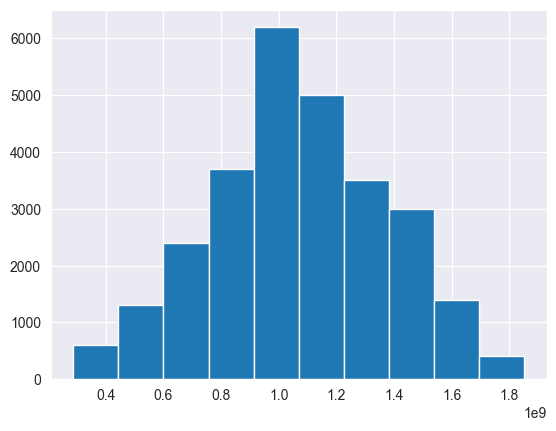

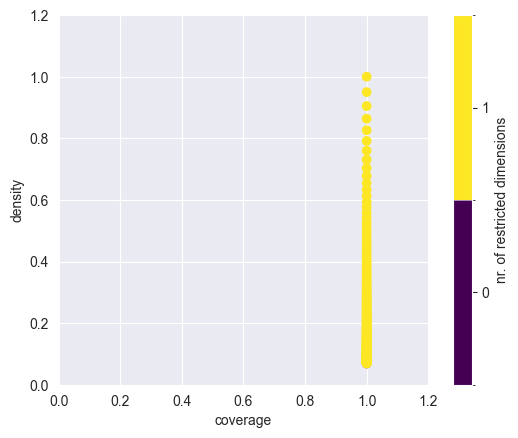

In [32]:
# See outcome
data_dike_inv = outcomes['Dike Investment Costs']

# Define wanted outcome
y_dike_inv = (data_dike_inv <= 600000000).astype(bool)

# plt.hist(data_dike_inv)

# PRIM-analyse
prim_alg_dike_inv = prim.Prim(cleaned_experiments, y_dike_inv, threshold=0.8)
box_dike_inv = prim_alg_dike_inv.find_box()
box_dike_inv.show_tradeoff()
plt.show()

coverage       1.000000
density        1.000000
id           256.000000
k           1900.000000
mass           0.069091
mean           1.000000
n           1900.000000
res_dim        1.000000
Name: 256, dtype: float64

                                                  box 256  \
                                                      min   
policy  {128, 132, 10, 150, 23, 159, 166, 41, 174, 181...   

                                                                             
                                                      max qp value qp value  
policy  {128, 132, 10, 150, 23, 159, 166, 41, 174, 181...      0.0      NaN  



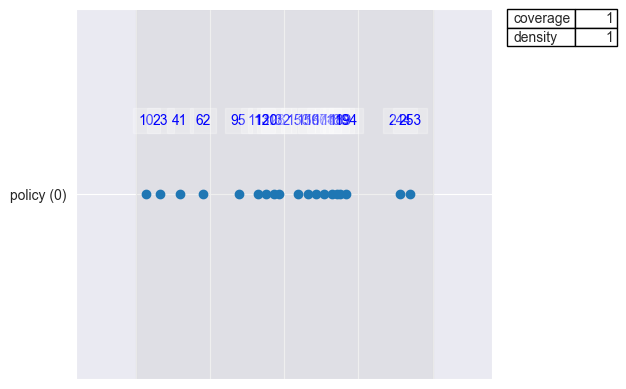

In [40]:
box_dike_inv.inspect()
box_dike_inv.inspect(style='graph')
plt.show()

In [12]:
# x = cleaned_experiments.reset_index(drop=True)
# # Boolean array van experimenten in de box
# in_box_dike_inv = box_dike_inv.yi  # Deze is altijd even lang als x na reset_index
#
# # Selecteer de experimenten die in de box vallen
# experiments_in_box_dike_inv = x.loc[in_box_dike_inv]
#
# # Unieke policies selecteren
# robust_policies_dike_inv = experiments_in_box_dike_inv['policy'].unique()
#
# # Robuuste policies opzoeken in originele experimenten
# robust_policies_df_dike_inv = experiments[experiments['policy'].isin(robust_policies_dike_inv)].drop_duplicates(subset='policy')
#
# # Toon resultaat
# print("Robust Policies for Dike Investment Costs:")
# display(robust_policies_df_dike_inv)

Robust Policies for Dike Investment Costs:


,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,EWS_DaysToThreat,scenario,policy,model
1000,103,217.683174,10.0,0.841797,270.954436,1.0,0.174278,337.892242,1.5,0.435198,...,6,6,3,8,10,10,0,275,10,dikesnet
2300,103,217.683174,10.0,0.841797,270.954436,1.0,0.174278,337.892242,1.5,0.435198,...,0,10,7,6,2,4,1,275,23,dikesnet
4100,103,217.683174,10.0,0.841797,270.954436,1.0,0.174278,337.892242,1.5,0.435198,...,6,4,2,2,9,9,3,275,41,dikesnet
6200,103,217.683174,10.0,0.841797,270.954436,1.0,0.174278,337.892242,1.5,0.435198,...,0,10,9,4,6,4,2,275,62,dikesnet
9500,103,217.683174,10.0,0.841797,270.954436,1.0,0.174278,337.892242,1.5,0.435198,...,10,5,3,1,4,8,4,275,95,dikesnet
11300,103,217.683174,10.0,0.841797,270.954436,1.0,0.174278,337.892242,1.5,0.435198,...,9,2,6,0,0,6,4,275,113,dikesnet
12000,103,217.683174,10.0,0.841797,270.954436,1.0,0.174278,337.892242,1.5,0.435198,...,0,9,7,1,10,5,4,275,120,dikesnet
12800,103,217.683174,10.0,0.841797,270.954436,1.0,0.174278,337.892242,1.5,0.435198,...,9,7,3,6,2,10,1,275,128,dikesnet
13200,103,217.683174,10.0,0.841797,270.954436,1.0,0.174278,337.892242,1.5,0.435198,...,8,7,3,3,8,9,2,275,132,dikesnet
15000,103,217.683174,10.0,0.841797,270.954436,1.0,0.174278,337.892242,1.5,0.435198,...,6,1,10,5,2,2,0,275,150,dikesnet


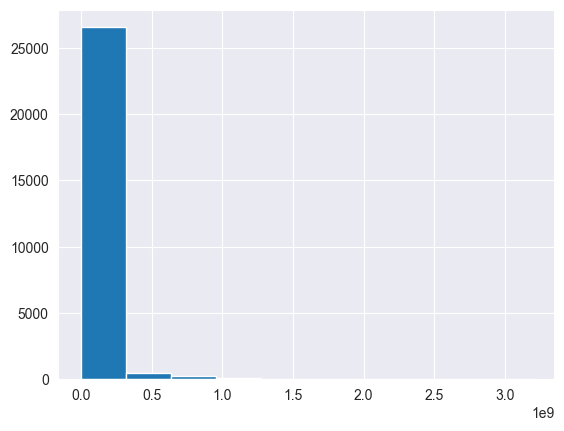

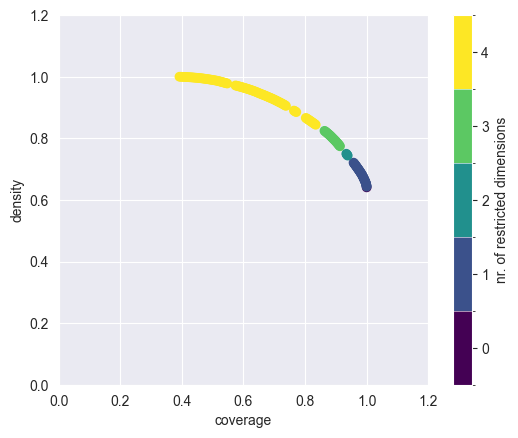

In [34]:
# See outcome
data_expanndamage = outcomes['Expected Annual Damage']

# See wanted outcome
y_expanndamage = (data_expanndamage <= 5000000).astype(bool)

# plt.hist(data_expanndamage)

# PRIM-analyse
prim_alg_expanndamage = prim.Prim(cleaned_experiments, y_expanndamage, threshold=0.8)
box_expanndamage = prim_alg_expanndamage.find_box()
box_expanndamage.show_tradeoff()
plt.show()

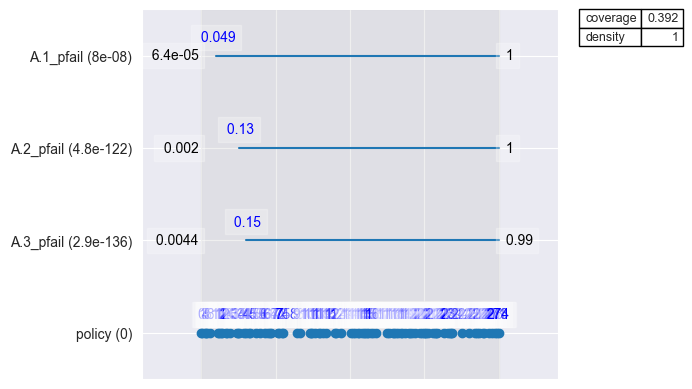

In [36]:
# box_expanndamage.inspect()
box_expanndamage.inspect(style='graph')
plt.show()

In [15]:
# x = cleaned_experiments.reset_index(drop=True)
# # Boolean array van experimenten in de box
# in_box_expanndamage = box_expanndamage.yi  # Deze is altijd even lang als x na reset_index
#
# # Selecteer de experimenten die in de box vallen
# experiments_in_box_expanndamage = x.loc[in_box_expanndamage]
#
# # Unieke policies selecteren
# robust_policies_expanndamage = experiments_in_box_expanndamage['policy'].unique()
#
# # Robuuste policies opzoeken in originele experimenten
# robust_policies_df_expanndamage = experiments[experiments['policy'].isin(robust_policies_expanndamage)].drop_duplicates(subset='policy')
#
# # Toon resultaat
# print("Robust Policies for Expected annual damage:")
# display(robust_policies_df_expanndamage)

Robust Policies for Expected annual damage:


,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,EWS_DaysToThreat,scenario,policy,model
0,103,217.683174,10.0,0.841797,270.954436,1.0,0.174278,337.892242,1.5,0.435198,...,9,6,4,2,5,7,0,275,0,dikesnet
100,103,217.683174,10.0,0.841797,270.954436,1.0,0.174278,337.892242,1.5,0.435198,...,5,3,7,10,1,7,4,275,1,dikesnet
300,103,217.683174,10.0,0.841797,270.954436,1.0,0.174278,337.892242,1.5,0.435198,...,9,4,2,3,9,8,2,275,3,dikesnet
400,103,217.683174,10.0,0.841797,270.954436,1.0,0.174278,337.892242,1.5,0.435198,...,4,0,6,1,3,9,0,275,4,dikesnet
500,103,217.683174,10.0,0.841797,270.954436,1.0,0.174278,337.892242,1.5,0.435198,...,9,4,4,9,7,8,2,275,5,dikesnet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26800,103,217.683174,10.0,0.841797,270.954436,1.0,0.174278,337.892242,1.5,0.435198,...,7,7,8,2,5,0,3,275,268,dikesnet
27100,103,217.683174,10.0,0.841797,270.954436,1.0,0.174278,337.892242,1.5,0.435198,...,6,9,2,6,3,4,3,275,271,dikesnet
27200,103,217.683174,10.0,0.841797,270.954436,1.0,0.174278,337.892242,1.5,0.435198,...,7,10,10,2,8,9,1,275,272,dikesnet
27300,103,217.683174,10.0,0.841797,270.954436,1.0,0.174278,337.892242,1.5,0.435198,...,5,0,1,10,6,0,1,275,273,dikesnet


In [16]:
# # Maak een samengestelde outcome "All Costs" aan door de drie relevante outcomes op te tellen
# # Zorg ervoor dat deze keys bestaan in je outcomes dictionary
# all_costs = (
#     outcomes["RfR Total Costs"] +
#     outcomes["Dike Investment Costs"] +
#     outcomes["Expected Annual Damage"]
# )
#
# # Voeg "All Costs" toe aan de outcomes dictionary voor verdere analyse
# outcomes["All Costs"] = all_costs


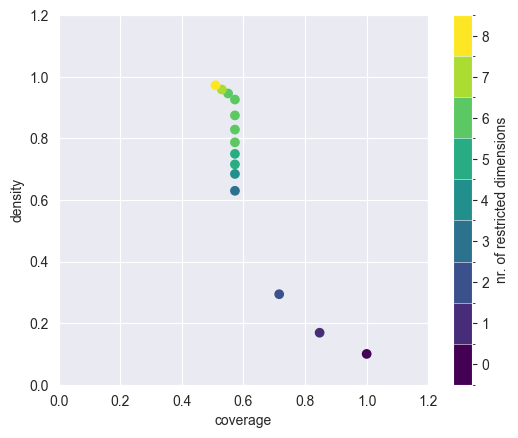

In [17]:
# from ema_workbench.analysis import prim
# import numpy as np
# import matplotlib.pyplot as plt
# import warnings
#
# # Vermijd Pandas dtype warning
# warnings.filterwarnings("ignore", category=FutureWarning)
#
# # Stel vulnerability condition in
# data_allcost = outcomes["All Costs"]
# y_allcost = (data_allcost < np.percentile(data_allcost, 10)).astype(int)
#
# # Voer PRIM uit
# prim_alg_allcost = prim.Prim(experiments, y_allcost, threshold=0.8)
# box_allcost = prim_alg_allcost.find_box()
# box_allcost.show_tradeoff()
# plt.show()

coverage       0.509091
density        0.972222
id            13.000000
k           1400.000000
mass           0.052364
mean           0.972222
n           1440.000000
res_dim        8.000000
Name: 13, dtype: float64

                                                               box 13  \
                                                                  min   
4_RfR 0                                                           0.0   
4_RfR 1                                                           0.0   
4_RfR 2                                                           0.0   
policy              {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
A.2_DikeIncrease 0                                                  2   
A.5_DikeIncrease 2                                                  1   
A.1_pfail                                                    0.048517   
A.3_pfail                                                    0.049877   

                                                   

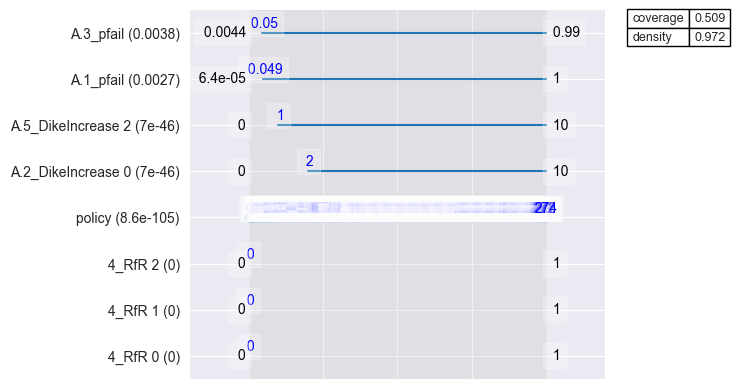

In [36]:
# box_allcost.inspect()
# box_allcost.inspect(style='graph')
# plt.show()

In [15]:
# x = cleaned_experiments.reset_index(drop=True)
# # Boolean array van experimenten in de box
# in_box_allcost = box_allcost.yi  # Deze is altijd even lang als x na reset_index
#
# # Selecteer de experimenten die in de box vallen
# experiments_in_box_allcost = x.loc[in_box_allcost]
#
# # Unieke policies selecteren
# robust_policies_allcost = experiments_in_box_allcost['policy'].unique()
#
# # Robuuste policies opzoeken in originele experimenten
# robust_policies_df_allcost = experiments[experiments['policy'].isin(robust_policies_allcost)].drop_duplicates(subset='policy')
#
# # Toon resultaat
# print("Robust Policies for Expected annual damage:")
# display(robust_policies_df_allcost)

Robust Policies for Expected annual damage:


,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,EWS_DaysToThreat,scenario,policy,model
1000,103,217.683174,10.0,0.841797,270.954436,1.0,0.174278,337.892242,1.5,0.435198,...,6,6,3,8,10,10,0,275,10,dikesnet
2300,103,217.683174,10.0,0.841797,270.954436,1.0,0.174278,337.892242,1.5,0.435198,...,0,10,7,6,2,4,1,275,23,dikesnet
4100,103,217.683174,10.0,0.841797,270.954436,1.0,0.174278,337.892242,1.5,0.435198,...,6,4,2,2,9,9,3,275,41,dikesnet
9500,103,217.683174,10.0,0.841797,270.954436,1.0,0.174278,337.892242,1.5,0.435198,...,10,5,3,1,4,8,4,275,95,dikesnet
10800,103,217.683174,10.0,0.841797,270.954436,1.0,0.174278,337.892242,1.5,0.435198,...,1,9,5,1,5,4,4,275,108,dikesnet
12000,103,217.683174,10.0,0.841797,270.954436,1.0,0.174278,337.892242,1.5,0.435198,...,0,9,7,1,10,5,4,275,120,dikesnet
12800,103,217.683174,10.0,0.841797,270.954436,1.0,0.174278,337.892242,1.5,0.435198,...,9,7,3,6,2,10,1,275,128,dikesnet
13200,103,217.683174,10.0,0.841797,270.954436,1.0,0.174278,337.892242,1.5,0.435198,...,8,7,3,3,8,9,2,275,132,dikesnet
15000,103,217.683174,10.0,0.841797,270.954436,1.0,0.174278,337.892242,1.5,0.435198,...,6,1,10,5,2,2,0,275,150,dikesnet
17400,103,217.683174,10.0,0.841797,270.954436,1.0,0.174278,337.892242,1.5,0.435198,...,4,4,9,4,6,8,1,275,174,dikesnet


In [16]:
# # Stap 1: Extract de unieke policy-namen per outcome
# set_rfr = set(robust_policies_df_rfrtotalcost['policy'])
# set_damage = set(robust_policies_df_expanndamage['policy'])
# set_allcost = set(robust_policies_df_allcost['policy'])
#
# # Stap 2: Vind de intersectie (policies die in alle drie voorkomen)
# robust_policies_all = set_rfr & set_damage & set_allcost
#
# # Stap 3: Filter originele experimenten op deze policies
# robust_policies_df_all = experiments[experiments['policy'].isin(robust_policies_all)].drop_duplicates(subset='policy')
#
# # Stap 4: Toon resultaat
# print("Robust Policies for ALL outcomes (intersection of all PRIM analyses):")
# display(robust_policies_df_all)


Robust Policies for ALL outcomes (intersection of all PRIM analyses):


,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,EWS_DaysToThreat,scenario,policy,model


In [27]:
# print(len(y_rfrtotalcost), len(y_dike_inv), len(y_expanndamage), len(cleaned_experiments))
#
# rfr_mask = box_rfrtotalcost.apply(cleaned_experiments)
# dike_mask = box_dike_inv.apply(cleaned_experiments)
# ead_mask = box_expanndamage.apply(cleaned_experiments)
#
# # 2. Combine the masks to find policies in ALL three boxes
# combined_mask = rfr_mask & dike_mask & ead_mask
#
# # 3. Extract those policies from the experiments
# best_policies = cleaned_experiments[combined_mask]
#
# # 4. (Optional) Show or save them
# import pandas as pd
# print(best_policies.head())

DIT KAN DENK IK WEG. HIER MOET DAN EIGEN TEKST MET UITLEG>

This figure shows the trade-off between coverage, density, and the number of restricted dimensions (i.e., a proxy for interpretability). Each dot corresponds to one candidate box. As an analyst, it is up to you to choose which box you want to inspect in more detail. Here you have to balance the three objectives. There is no hard rule that is used here. Note, however, that a density of lower than 0.5 means that less than half of the cases within the box of interest are of interest. So ideally, you start with higher density boxes. Moreover, you want boxes for which the box limits are statistically significant according to the quasi p-values. This means that the last box for a given number of restricted dimensions is also a good candidate box to inspect (here, for example, the last box with 2 dimensions and the last box with 3 dimensions).

This figure shows in gray the complete interval for each parameter. A blue line is used in the case of RealParameters to show the interval of the box identified by PRIM. For CategoricalParameters, a dot is used instead. The blue numbers give the specific limit. The numbers behind the y-labels indicate the quasi p-values. In the top right-hand corner, you can see the coverage and density of the identified box. So, what do we see in this case. First, both delta and stdev are not significant and should be ignored in the interpretation. This leaves b, q, and some of the policies as the key determinants. So, our top 10% worst performance for reliability occurs if b and q are low and for 6 out of the 10 policies. This covers 56% of the cases of interest, with a precision (i.e. density) of 80%. Now, you would go back to the model and try to understand why you get low reliability if b and q are low.

## 2. Visualize the results using Dimensional Stacking
Take the classification of outcomes as used in step 3 of scenario discovery, and instead visualize the results using dimensional stacking. How do these results compare to the insights from scenario discovery?

In [17]:
from ema_workbench.analysis import dimensional_stacking

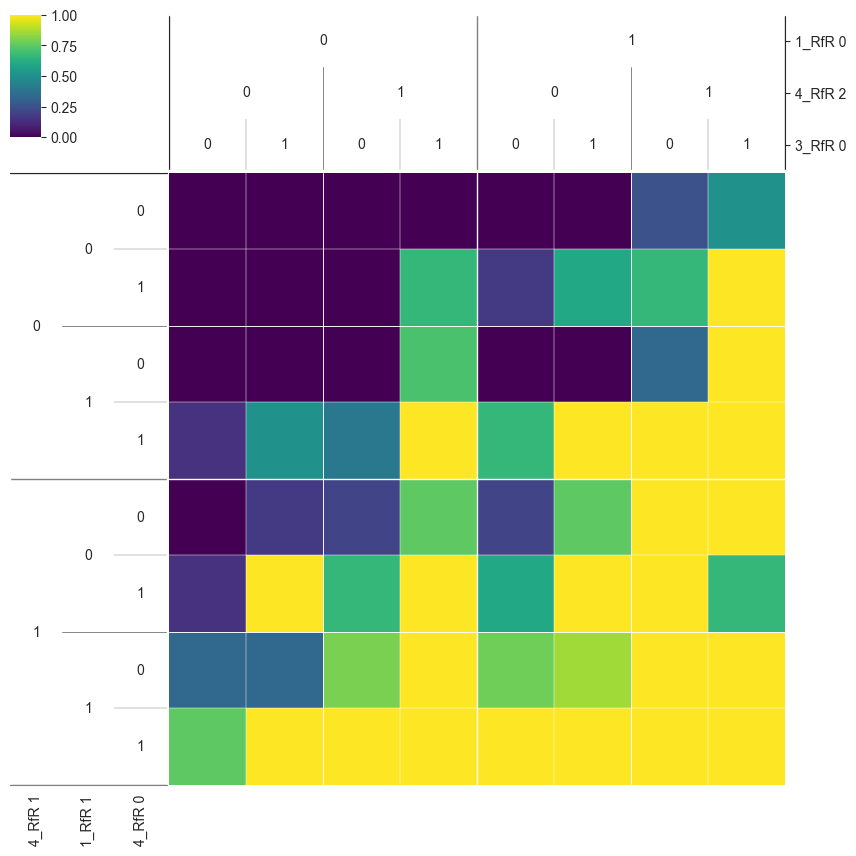

In [18]:
dimensional_stacking.create_pivot_plot(experiments, y_rfrtotalcost)
plt.show()

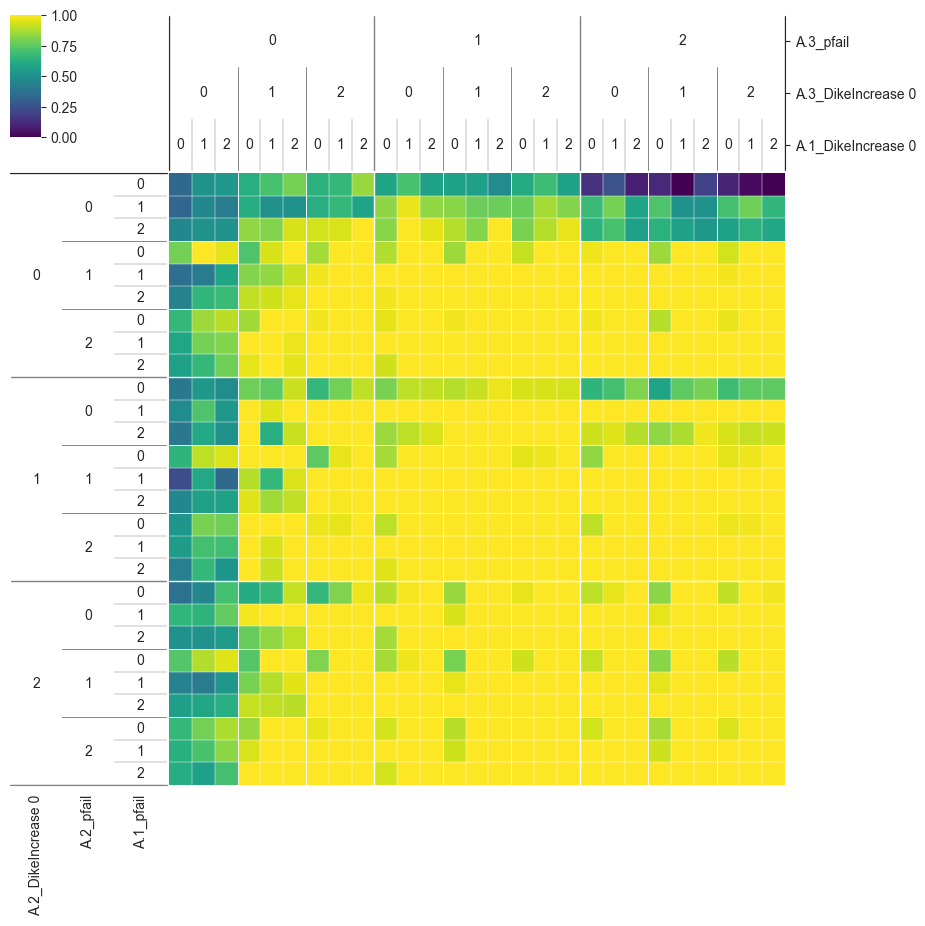

In [19]:
dimensional_stacking.create_pivot_plot(experiments,y_expanndamage)
plt.show()

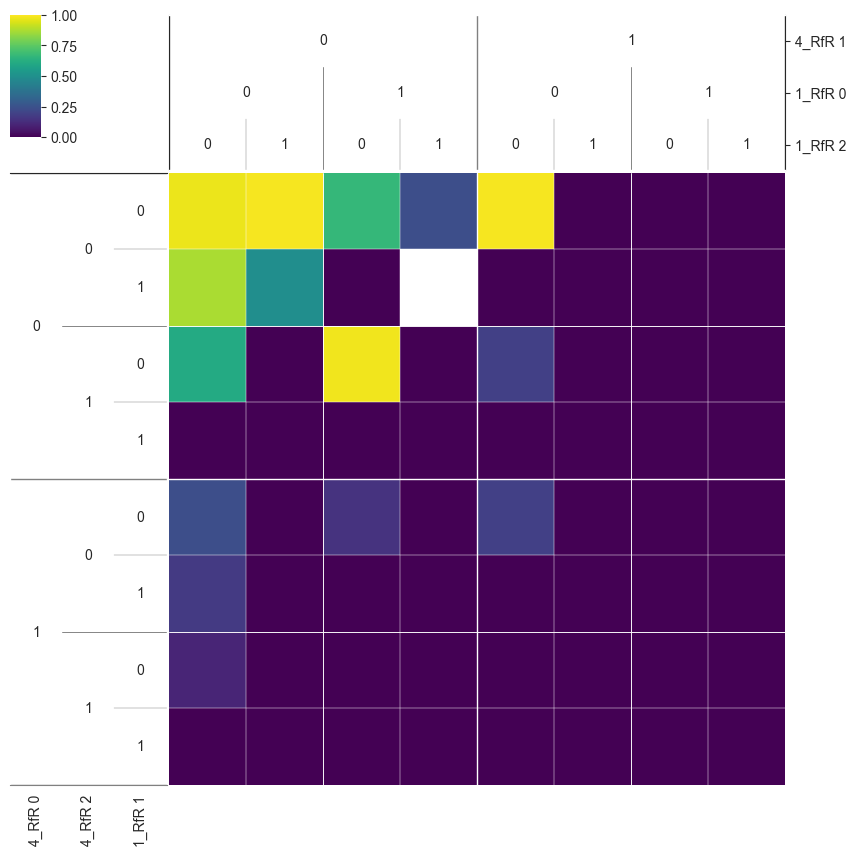

In [20]:
dimensional_stacking.create_pivot_plot(experiments,y_dike_inv)
plt.show()


DIT KAN WRS WEG. EIGEN TEKST HIER

As you can see, with the additional runs there are at least no white spaces left anymore. This is a good indication that we have a good coverage of the space.

#### Concluding remarks
In this notebook, we have applied several techniques for scenario discovery to the inter temporal version of the lake problem (i.e., the one with 100 decision variables). Both dimensional stacking and PRIM point to the importance of low values for the b and q parameters in driving low reliability. The last, qualitative, step is to go back to the model and offer a structural explanation (remember from system dynamics: structure explains behavior) for this behavior. So why do you get low reliability of b and q are low?